<a href="https://colab.research.google.com/github/ewertonsilvag/Projeto_Conclusao_SoulCode/blob/main/DataFrame_Ethereum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Conexão GCP para ingestão dos dados

 #### autenticação de acesso a bucket GCP para INGESTÃO dos dados 

In [ ]:
#Importando biblioteca para autenticar conexão com GCP

from google.colab import auth

In [ ]:
project_id = 'projeto-grupo2-economia'
bucket_name = 'economia-dados-g2'

auth.authenticate_user()

In [ ]:
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
#Enviando o DATASET bruto para o bucket de entrada 

#!gsutil cp /content/drive/MyDrive/ProjetoFinal/crypto/ethereum.json gs://{bucket_name}/entrada/Ethereum_Bruto.json

In [ ]:
#Download dos dados para o Drive para usar no Colab

#!gsutil cp gs://{bucket_name}/entrada/Ethereum_Bruto.json /content/drive/MyDrive/ProjetoFinal/crypto/ethereum_entrada.json

# Pandas

#### Instalação e importação de bibliotecas

In [ ]:
#Importando a biblioteca

import pandas as pd

In [ ]:
#Ingestão dos dados

df = pd.read_json('/content/drive/MyDrive/ProjetoFinal/crypto/ethereum_entrada.json')
df

#### Limpeza e Tratamento de Dados

In [ ]:
#Renomeando todas as colunas traduzindo-as para o português
#Comentário -01

df.rename(columns={
    'SNo':'Id',
    'Symbol':'Sigla',
    'Date':'Data',
    'Name':'Moeda',
    'Open':'Preco_Abertura',
    'Close':'Preco_Fechamento',
    'Low':'Menor_Preco',
    'High':'Maior_Preco',
    'Volume':'Volume',
    'Marketcap':'Capitalizacao_Mercado'
}, inplace=True)

In [ ]:
#Verificando se todas as alterações foram feitas e os tipos de dados das colunas

df.dtypes

In [ ]:
#Verificando a presença de nulos no dataset
df.isnull().sum()

In [ ]:
df

In [ ]:
#Tranformando a visualização dos valores para melhor compreensão com duas casas decimais
#Comentário -02

pd.options.display.float_format = '{:,.2f}'.format


In [ ]:
#Verificando se os dados contidos na coluna Id são únicos para usá-lo como meu index
df.Id.is_unique

In [ ]:
#Após a confirmação de cima, aqui está sendo colocada a coluna Id como index
df.set_index('Id', inplace=True)

In [ ]:
#Normalizando a data tirando as horas

df['Data'] = pd.to_datetime(df['Data']).dt.normalize()

In [ ]:
#Verificando se o dataset ta ok
df

## Plotagem

### Criando minidataframe para plotagem 1 (Preço Fechamento mar de 2018)

In [ ]:
#Comentário -04

In [ ]:
colunas_selecionadas_plotagem = ['Data','Preco_Fechamento']

In [ ]:
df1=df.filter(items=colunas_selecionadas_plotagem)

In [ ]:
df1 = df1.query("Data >= '2018-03-01' & Data <= '2018-03-31'")

In [ ]:
df1

### Criando minidataframe para plotagem 2 (Preço Fechamento mar de 2019)

In [ ]:
colunas_selecionadas_plotagem2 = ['Data','Preco_Fechamento']

In [ ]:
df2=df.filter(items=colunas_selecionadas_plotagem2)

In [ ]:
df2 = df2.query("Data >= '2019-03-01' & Data <= '2019-03-31'")

### Criando minidataframe para plotagem 3 (Preço Fechamento mar de 2020)

In [ ]:
colunas_selecionadas_plotagem3 = ['Data','Preco_Fechamento']

In [ ]:
df3=df.filter(items=colunas_selecionadas_plotagem3)

In [ ]:
df3 = df3.query("Data >= '2020-03-01' & Data <= '2020-03-31'")

### Criando minidataframe para plotagem 4 (Preço Fechamento mar de 2021)

In [ ]:
colunas_selecionadas_plotagem4 = ['Data','Preco_Fechamento']

In [ ]:
df4=df.filter(items=colunas_selecionadas_plotagem4)

In [ ]:
df4 = df4.query("Data >= '2021-03-01' & Data <= '2021-03-31'")

###Plotagens

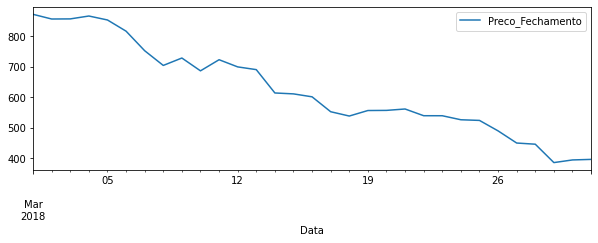

In [ ]:
#Preço de Fechamento da ethereum no mês de março de 2018
#Comentário -05

df1.plot(x='Data',y='Preco_Fechamento',kind='line',figsize=(10, 3))


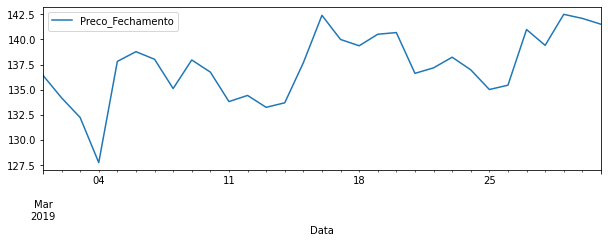

In [ ]:
#Preço de Fechamento da ethereum no mês de março de 2019
df2.plot(x='Data',y='Preco_Fechamento',kind='line',figsize=(10, 3))

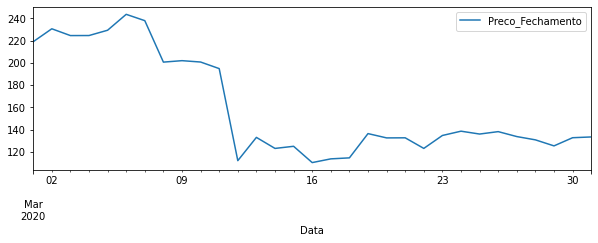

In [ ]:
#Preço de Fechamento da ethereum no mês de março de 2020
df3.plot(x='Data',y='Preco_Fechamento',kind='line',figsize=(10, 3))

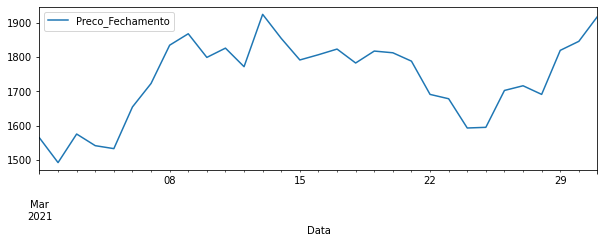

In [ ]:
#Preço de Fechamento da ethereum no mês de março de 2021
df4.plot(x='Data',y='Preco_Fechamento',kind='line',figsize=(10, 3))

## Load do dataset no GCP

In [ ]:
#Transformando os dados em csv e salvando no Drive
#Comentário -03

#df.to_csv("/content/drive/MyDrive/ProjetoFinal/crypto/ethereum_pandas.csv", index=True)

In [ ]:
#Enviando tabela em csv para a cloud

#!gsutil cp /content/drive/MyDrive/ProjetoFinal/crypto/ethereum_pandas.csv gs://{bucket_name}/saida/dados_pandas/

# Pyspark

##Configurações e instalações

In [ ]:
#Download da tabela normalizada com Pandas

#!gsutil cp gs://{bucket_name}/saida/dados_pandas/ethereum_pandas.csv /content/drive/MyDrive/ProjetoFinal/crypto/ethereum_pandas_tratada.csv

In [ ]:
#Instalando o pyspark
!pip install pyspark

In [ ]:
#Importando as bibliotecas necessárias

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, FloatType, DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import *


In [ ]:
#Configurando nosso SparkSession
#Comentário -05

spark = (SparkSession.builder\
        .master("local")\
        .appName("dataframe.ethereum")\
        .config("spark.ui.port", "4050")\
        .getOrCreate())
spark

In [ ]:
# Montando a estrutura do DataFrame 
#Comentário -06

schema= StructType([
    StructField('Id',IntegerType(),True),
    StructField('Moeda',StringType(),True),                
    StructField('Sigla',StringType(),True),
    StructField('Data',DateType(),True),
    StructField('Maior_Preco',FloatType(),True),
    StructField('Menor_Preco',FloatType(),True),
    StructField('Preco_Abertura',FloatType(),True),
    StructField('Preco_Fechamento',FloatType(),True),
    StructField('Volume',FloatType(),True),
    StructField('Capitalizacao_Mercado',FloatType(),True)])

local=('/content/drive/MyDrive/ProjetoFinal/crypto/ethereum_pandas_tratada.csv')
df_ethereum = spark.read.load(local, format="csv", header="true", sep=',', schema=schema)

In [ ]:
#Verificando os tipos de dados da coluna

df_ethereum.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Moeda: string (nullable = true)
 |-- Sigla: string (nullable = true)
 |-- Data: date (nullable = true)
 |-- Maior_Preco: float (nullable = true)
 |-- Menor_Preco: float (nullable = true)
 |-- Preco_Abertura: float (nullable = true)
 |-- Preco_Fechamento: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Capitalizacao_Mercado: float (nullable = true)



## Extraindo insights 

Verificando todo o DataFrame

In [ ]:
df_ethereum.show()

Criando uma nova coluna verificando os dias que a moeda fechou em alta ou não

In [ ]:
df_ethereum1 = (df_ethereum.withColumn("Valorizou_No_Dia", 
       F.when(F.col("Preco_Fechamento") > F.col("Preco_Abertura"), F.lit("SIM"))
        .otherwise("NAO")))
df_ethereum1.show()

Selecionando apenas as datas em que o preço de fechamento foi maior do que o da abertura

In [ ]:
df_ethereum1.select(F.col('Data'),F.col('Sigla'),F.col('Preco_Abertura'),F.col('Preco_Fechamento')).filter(F.col('Valorizou_No_Dia')== 'SIM').show(10)

+----------+-----+--------------+----------------+
|      Data|Sigla|Preco_Abertura|Preco_Fechamento|
+----------+-----+--------------+----------------+
|2015-08-11|  ETH|      0.708087|         1.06786|
|2015-08-12|  ETH|       1.05875|         1.21744|
|2015-08-13|  ETH|       1.22224|         1.82767|
|2015-08-14|  ETH|       1.81092|         1.82787|
|2015-08-19|  ETH|       1.16693|         1.25886|
|2015-08-20|  ETH|       1.25118|         1.46492|
|2015-08-26|  ETH|       1.13279|         1.15998|
|2015-08-28|  ETH|       1.14766|         1.19138|
|2015-08-30|  ETH|       1.18299|         1.31927|
|2015-08-31|  ETH|       1.32138|         1.35824|
+----------+-----+--------------+----------------+
only showing top 10 rows



Verificando a média geral dos maiores preços da moeda 

In [ ]:
df_ethereum1.groupby().mean("Maior_Preco").show()


+-----------------+
| avg(Maior_Preco)|
+-----------------+
|398.2585684068501|
+-----------------+



Selecionando o maior preço da Ethereum entre o intervalo de data do dataframe

In [ ]:
df_ethereum1.select(F.max(F.col("Maior_Preco"))).show(truncate=False)


+----------------+
|max(Maior_Preco)|
+----------------+
|4362.3506       |
+----------------+



Selecionando o menor preço da Ethereum entre o intervalo de data do dataframe

In [ ]:
df_ethereum1.select(F.min(F.col("Menor_Preco"))).show(truncate=False)


+------------------+
|min(Menor_Preco)  |
+------------------+
|0.4208970069885254|
+------------------+



Selecionando algumas colunas filtrando pela nova coluna criada com base na valorização

In [ ]:
df_ethereum_valorizacao = df_ethereum1.select(F.col("Data"),F.col("Sigla"),F.col("Preco_Abertura"),F.col("Preco_Fechamento"),F.col("Valorizou_No_Dia")).filter(F.col("Valorizou_No_Dia") == "SIM").show(10)

+----------+-----+------------------+------------------+----------------+
|      Data|Sigla|    Preco_Abertura|  Preco_Fechamento|Valorizou_No_Dia|
+----------+-----+------------------+------------------+----------------+
|2015-08-11|  ETH|0.7080870270729065|1.0678600072860718|             SIM|
|2015-08-12|  ETH| 1.058750033378601|1.2174400091171265|             SIM|
|2015-08-13|  ETH|1.2222399711608887|1.8276699781417847|             SIM|
|2015-08-14|  ETH| 1.810920000076294|1.8278700113296509|             SIM|
|2015-08-19|  ETH|1.1669299602508545|1.2588599920272827|             SIM|
|2015-08-20|  ETH|1.2511800527572632|1.4649200439453125|             SIM|
|2015-08-26|  ETH| 1.132789969444275| 1.159980058670044|             SIM|
|2015-08-28|  ETH|1.1476600170135498|1.1913800239562988|             SIM|
|2015-08-30|  ETH|1.1829899549484253|1.3192700147628784|             SIM|
|2015-08-31|  ETH|1.3213800191879272| 1.358240008354187|             SIM|
+----------+-----+------------------+-

## Load para o GCP e Drive

In [ ]:
#Convertendo Spark_df para Pandas_df
df_ethereum_pd = df_ethereum.toPandas()


In [ ]:
#Salvando Spark to Pandas no Drive

df_ethereum_pd.to_csv('/content/drive/MyDrive/ProjetoFinal/crypto/ethereum_pyspark.csv', index = False)

In [ ]:
#Envio de dados para o bucket
!gsutil cp /content/drive/MyDrive/ProjetoFinal/crypto/ethereum_pyspark.csv gs://{bucket_name}/saida/dados_pyspark/

Copying file:///content/drive/MyDrive/ProjetoFinal/crypto/ethereum_pyspark.csv [Content-Type=text/csv]...
/ [1 files][254.2 KiB/254.2 KiB]                                                
Operation completed over 1 objects/254.2 KiB.                                    


# SparkSQL

## Ingestão e configurações

In [ ]:
#!gsutil cp gs://{bucket_name}/saida/dados_pyspark/ethereum_pyspark.csv /content/drive/MyDrive/ProjetoFinal/crypto/ethereum_spark_sql.csv 

BadRequestException: 400 Invalid bucket name: '{bucket_name}'


In [ ]:
df_ethereum_sql = (spark
                .read
                .format("csv")
                .option("header","true")
                .option("inferschema", "true")
                .option("delimiter", ",")
                .load("/content/drive/MyDrive/ProjetoFinal/crypto/ethereum_spark_sql.csv")
                .createOrReplaceTempView("tabela_ethereum"))

In [ ]:
#Identificando as colunas e os tipos de dados do DataFrame
spark.sql(
'''
describe tabela_ethereum'''
).show()

## Consultas

In [ ]:
#Mostrando todas as colunas do DataFrame

spark.sql('''SELECT * FROM tabela_ethereum''').show()

+---+--------+-----+----------+------------------+------------------+------------------+------------------+---------+---------------------+
| Id|   Moeda|Sigla|      Data|       Maior_Preco|       Menor_Preco|    Preco_Abertura|  Preco_Fechamento|   Volume|Capitalizacao_Mercado|
+---+--------+-----+----------+------------------+------------------+------------------+------------------+---------+---------------------+
|  1|Ethereum|  ETH|2015-08-08|2.7988100051879883|0.7147250175476074| 2.793760061264038|0.7533249855041504| 674188.0|      4.54868942408E7|
|  2|Ethereum|  ETH|2015-08-09|0.8798099756240845| 0.629190981388092|0.7061359882354736|0.7018970251083374| 532170.0|      4.23995734991E7|
|  3|Ethereum|  ETH|2015-08-10|0.7298539876937866|0.6365460157394409|0.7139890193939209|0.7084479928016663| 405283.0|      4.28183643945E7|
|  4|Ethereum|  ETH|2015-08-11| 1.131410002708435|0.6632350087165833|0.7080870270729065|1.0678600072860718|1463100.0|      6.45692884328E7|
|  5|Ethereum|  ETH|

In [ ]:
#verificando a data inicial e final dos registros 

spark.sql('''SELECT MIN(Data) AS Data_Inicial,
MAX(Data) AS Data_Final
FROM tabela_ethereum
''').show()

+------------+----------+
|Data_Inicial|Data_Final|
+------------+----------+
|  2015-08-08|2021-07-06|
+------------+----------+



In [ ]:
#verificando a maior e a menor capitalizção já registrada entre 08-08-2015 a 06-07-2021
+------------+----------

spark.sql('''SELECT MIN(Capitalizacao_Mercado) AS Capitalizacao_Minima,
MAX(Capitalizacao_Mercado) AS Capitalizacao_Maxima
FROM tabela_ethereum
''').show()

+--------------------+--------------------+
|Capitalizacao_Minima|Capitalizacao_Maxima|
+--------------------+--------------------+
|     3.22136261748E7|  4.8288190049093E11|
+--------------------+--------------------+



In [ ]:
#Preço de fechamento da ethereum na data de 01-03-2020 até 31-03-2020

spark.sql(''' SELECT Moeda, Data, Preco_Fechamento
FROM tabela_ethereum
WHERE Data LIKE "2020-03%" 
''').show(31)

In [ ]:
#Mostrando as datas onde o preço de fechamento foi maior que o de abertura
spark.sql(''' SELECT Sigla, Data, Preco_Fechamento
FROM tabela_ethereum
WHERE Preco_Fechamento > Preco_Abertura
''').show()

In [ ]:
#Mostrando os dados da ethereum na data 01/01/2020
spark.sql('''SELECT * FROM tabela_ethereum 
WHERE Data LIKE '2020-01-01'
''').show()

In [ ]:
#Verificando as datas onde a ethereum teve os maiores preços

spark.sql(''' SELECT Sigla, Data, Maior_Preco
FROM tabela_ethereum
ORDER BY Maior_Preco DESC
''').show()

+-----+----------+-------------+
|Sigla|      Data|  Maior_Preco|
+-----+----------+-------------+
|  ETH|2021-05-12| 4362.3505418|
|  ETH|2021-05-10|4197.47327657|
|  ETH|2021-05-11|4178.20881516|
|  ETH|2021-05-14|4171.01696316|
|  ETH|2021-05-15|4129.18552263|
|  ETH|2021-05-13| 4032.5635388|
|  ETH|2021-05-09|  3981.259091|
|  ETH|2021-05-08|3950.16493281|
|  ETH|2021-05-16|3878.89597502|
|  ETH|2021-05-06| 3598.8958895|
|  ETH|2021-05-17| 3587.7656099|
|  ETH|2021-05-07|      3573.29|
|  ETH|2021-05-18|3562.46515966|
|  ETH|2021-05-05|3541.46264636|
|  ETH|2021-05-04|3523.58582135|
|  ETH|2021-05-03| 3450.0378763|
|  ETH|2021-05-19|3437.93578796|
|  ETH|2021-05-20|2993.14518268|
|  ETH|2021-05-02|2984.89188214|
|  ETH|2021-05-01|2951.44095688|
+-----+----------+-------------+
only showing top 20 rows



In [ ]:
#Mostrando as datas onde foram registrados os menores preços para a ethereum
spark.sql(''' SELECT Sigla, Data, Menor_Preco
FROM tabela_ethereum
ORDER BY Menor_Preco
''').show()

+-----+----------+-------------------+
|Sigla|      Data|        Menor_Preco|
+-----+----------+-------------------+
|  ETH|2015-10-21| 0.4208970069885254|
|  ETH|2015-10-22| 0.4209910035133362|
|  ETH|2015-10-20|0.43164798617362976|
|  ETH|2015-10-19|0.48099398612976074|
|  ETH|2015-10-14|0.48397400975227356|
|  ETH|2015-10-23| 0.5042840242385864|
|  ETH|2015-10-18| 0.5128610134124756|
|  ETH|2015-10-15| 0.5147299766540527|
|  ETH|2015-10-24| 0.5186880230903625|
|  ETH|2015-10-16| 0.5225329995155334|
|  ETH|2015-10-17| 0.5269610285758972|
|  ETH|2015-09-28| 0.5570619702339172|
|  ETH|2015-09-29| 0.5583459734916687|
|  ETH|2015-10-25| 0.5613830089569092|
|  ETH|2015-10-08| 0.5919709801673889|
|  ETH|2015-10-26| 0.5970979928970337|
|  ETH|2015-10-13| 0.5992140173912048|
|  ETH|2015-10-07| 0.6024230122566223|
|  ETH|2015-10-06| 0.6062300205230713|
|  ETH|2015-10-11| 0.6183350086212158|
+-----+----------+-------------------+
only showing top 20 rows



In [ ]:
spark.sql(''' SELECT Sigla, Data, Capitalizacao_Mercado
FROM tabela_ethereum
ORDER BY Capitalizacao_Mercado DESC
''').show()

+-----+----------+---------------------+
|Sigla|      Data|Capitalizacao_Mercado|
+-----+----------+---------------------+
|  ETH|2021-05-11|   4.8288190049093E11|
|  ETH|2021-05-14|   4.7266357078842E11|
|  ETH|2021-05-10|   4.5776121980687E11|
|  ETH|2021-05-09|   4.5499199490007E11|
|  ETH|2021-05-08|   4.5190565009371E11|
|  ETH|2021-05-12|   4.3858507567354E11|
|  ETH|2021-05-13|   4.3044528230128E11|
|  ETH|2021-05-15|   4.2161909068282E11|
|  ETH|2021-05-16|    4.158015349619E11|
|  ETH|2021-05-05|     4.07777080466E11|
|  ETH|2021-05-06|   4.0413139479206E11|
|  ETH|2021-05-07|   4.0346570289742E11|
|  ETH|2021-05-03|   3.9706978647946E11|
|  ETH|2021-05-18|   3.9185029526305E11|
|  ETH|2021-05-17|   3.8048284386521E11|
|  ETH|2021-05-04|   3.7657739957376E11|
|  ETH|2021-05-02|   3.4159313388594E11|
|  ETH|2021-05-01|   3.4084044435406E11|
|  ETH|2021-05-26|   3.3519648564587E11|
|  ETH|2021-06-03|   3.3160813310108E11|
+-----+----------+---------------------+
only showing top

# ApacheBeam

In [ ]:
pip install apache-beam[interactive]

In [ ]:
import apache_beam as beam

In [ ]:
p1 = beam.Pipeline ()

ethereum = (
    p1
    |'Extrair os dados' >> beam.io.ReadFromText('/content/drive/MyDrive/ProjetoFinal/crypto/ethereum_pyspark.csv', skip_header_lines= 0)
    |'Separador' >> beam.Map(lambda record: record.split(','))
    |'Saida de dados' >> beam.Map(print)
    #|'Gravar resultados'>> beam.io.WriterToText('resultado_ethereum.txt')
)
p1.run()

In [ ]:
p2 = beam.Pipeline()

ethereum_data = (
    p2
    |'Extrair os dados' >> beam.io.ReadFromText('/content/drive/MyDrive/ProjetoFinal/crypto/ethereum_pyspark.csv', skip_header_lines= 0)
    |'Separador' >> beam.Map(lambda record: record.split(','))
    |'Data da consulta' >> beam.Filter(lambda record : (record[3]) == '2020-05-31') #selecionando na coluna Data = 31 DE MAIO DE 2020
    |'Agregação de colunas' >> beam.Map(lambda record: (record[1], float(record[7]))) #selecionando o preço de fechamento da referida data
    |'Saída de Dados' >> beam.Map(print)
 
)
p2.run()


('Ethereum', 230.975700856)
